# Anomaly Detection for Santa Cruz Islands Animl Dataset

Make sure you have the image path-labels csvs and the zip file of the data uploaded to the colab file system.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import itertools

# 1. Label Cleaning & EDA
Clean up the labels and visualize the species distribution.

In [2]:
labels_df = pd.read_csv('/content/SCI_biodiversity_images_and_labels.csv')
labels_df.head()

,image_path,species_label
0,cropped_images/sci_biosecurity-c3ae90a3d9a22d9...,fox
1,cropped_images/sci_biosecurity-0e1bb2d5f0cfaad...,opossum
2,cropped_images/sci_biosecurity-fe89dfedaa00dc1...,opossum
3,cropped_images/sci_biosecurity-d1a8ad87dd68a02...,opossum
4,cropped_images/sci_biosecurity-8eec8e106a41356...,fox


In [5]:
print(f"Total number of images after cropping = {labels_df.shape[0]}")

Total number of images after cropping = 109903


In [6]:
labels_df['species_label'].unique()

array(['fox', 'opossum', 'rodent', 'bird', 'rat', 'skunk', 'scrub jay',
       'lizard', 'mouse', 'dog', 'vole', 'insect', 'squirrel', 'bat',
       'snake', 'bug', 'rodnet', 'liz', 'butterfly', 'frog',
       'striped skunk'], dtype=object)

In [3]:
# clean label typos
clean_labels = {'liz':'lizard', 'rodnet':'rodent', 'striped skunk': 'skunk', 'bug':'insect'}
labels_df['species_label'] = labels_df['species_label'].apply(lambda x: clean_labels.get(x, x))
labels_df['species_label'].unique()

array(['fox', 'opossum', 'rodent', 'bird', 'rat', 'skunk', 'scrub jay',
       'lizard', 'mouse', 'dog', 'vole', 'insect', 'squirrel', 'bat',
       'snake', 'butterfly', 'frog'], dtype=object)

In [4]:
# only keep the most specific species categories (for example: mouse, rat not rodent)
keep_labels = ['fox', 'opossum', 'rat', 'skunk', 'scrub jay', 'lizard', 'mouse', 'dog', 'vole', 'squirrel', 'bat',
               'snake', 'butterfly', 'frog']
filtered_labels_df = labels_df[labels_df['species_label'].isin(keep_labels)]
print(f"Total number of images after filtering top-level species = {filtered_labels_df.shape[0]}")

Total number of images after filtering top-level species = 28731


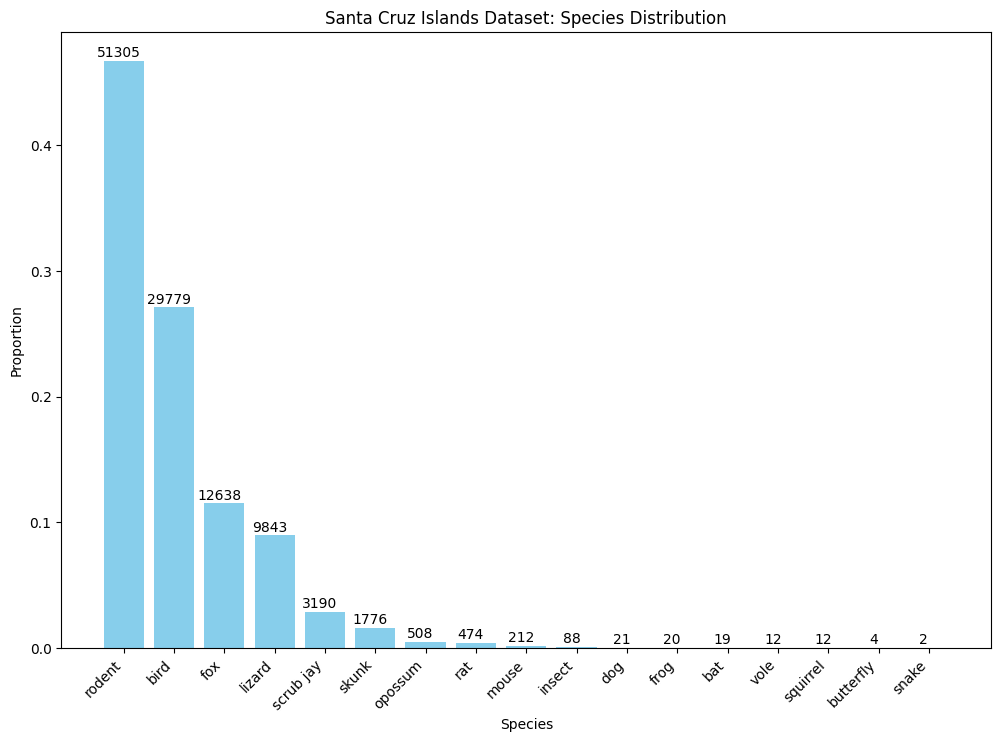

In [9]:
# visualize species distribution - before
species_proportions = labels_df['species_label'].value_counts(normalize=True).reset_index()
species_proportions.columns = ['species', 'proportion']

plt.figure(figsize=(12, 8))
bars = plt.bar(species_proportions['species'], species_proportions['proportion'], color='skyblue')

# annotating each bar with its count
for bar, count in zip(bars, labels_df['species_label'].value_counts()):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.001, f'{count}', ha='center', va='bottom')

plt.xlabel('Species')
plt.ylabel('Proportion')
plt.title('Santa Cruz Islands Dataset: Species Distribution')
plt.xticks(rotation=45, ha='right')
plt.show()

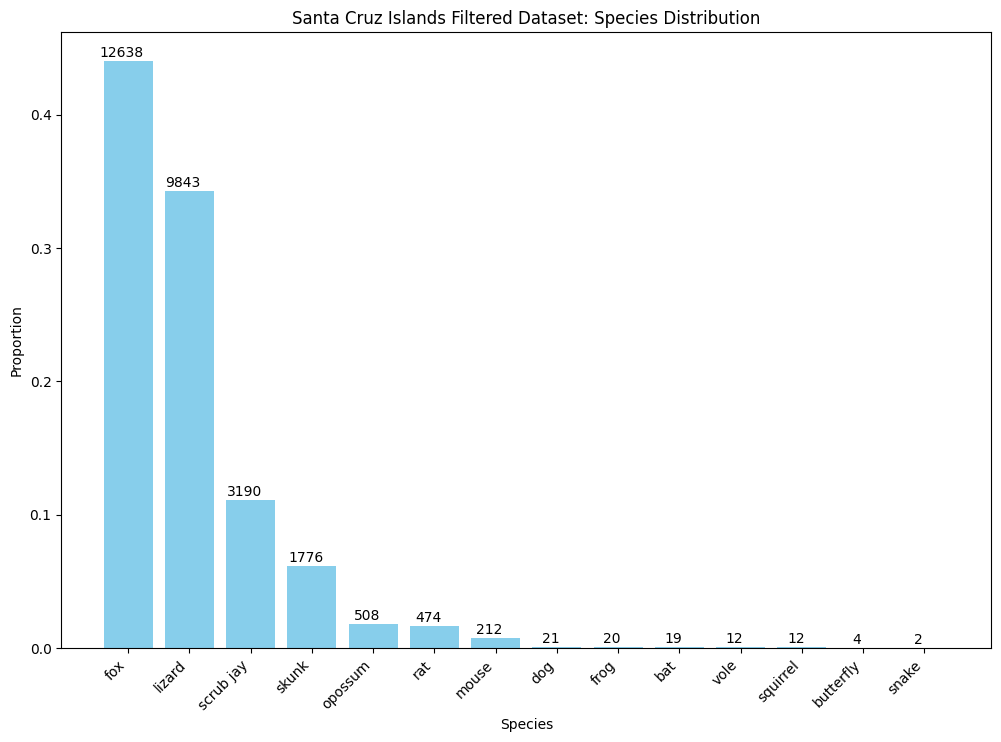

In [10]:
# visualize species distribution - after
species_proportions = filtered_labels_df['species_label'].value_counts(normalize=True).reset_index()
species_proportions.columns = ['species', 'proportion']

plt.figure(figsize=(12, 8))
bars = plt.bar(species_proportions['species'], species_proportions['proportion'], color='skyblue')

# annotating each bar with its count
for bar, count in zip(bars, filtered_labels_df['species_label'].value_counts()):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.001, f'{count}', ha='center', va='bottom')

plt.xlabel('Species')
plt.ylabel('Proportion')
plt.title('Santa Cruz Islands Filtered Dataset: Species Distribution')
plt.xticks(rotation=45, ha='right')
plt.show()

In [5]:
# based on the species proportions let's hold out the low volume species as invasive
invasive = ['dog','frog','bat','vole','squirrel','butterfly','snake']
non_invasive = ['fox','lizard','scrub jay','skunk','opossum','rat','mouse']

# 2. Anomaly detection with hold out set
For each "invasive" species, we train an autoencoder on the other ("native") species (hold out the "invasive" species). During the training process, we calculate a correlation threshold which is the correlation between the original "native" species data and the trained autoencoder repersentation of the "native" species data. We can further weight this correlation with a constant c. Then during inference, we use our trained autoencoder to predict a repersentation of the "invasive" species. If the correlation between the autoencoder repersentation and original "invasive" species data is less than the correlation threshold scaled by some constant c, it is predicted as an "anomlous" or "invasive" species, otherwise it is a "native" species. We can hyperparameter tune for the value of c.

In [14]:
!unzip /content/sci_images.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/cropped_images/sci_biosecurity-85887b5d24624f8be8a3a499676d45a9.jpg  
  inflating: /content/cropped_images/26eaa8c4456cfb76394a273612987cc0.jpg  
  inflating: /content/cropped_images/sci_biosecurity-2e9f109b03f94b0b7e3c73a90b58c064.jpg  
  inflating: /content/cropped_images/bdaed811070bc682be4058025cb198b8.jpg  
  inflating: /content/cropped_images/sci_biosecurity-00b08da242910b42433c29f1f3667962.jpg  
  inflating: /content/cropped_images/0708b2ea63d092ce52f38b846d2293b1.jpg  
  inflating: /content/cropped_images/8fefca871a7fa5fce3073601ffac6eaa.jpg  
  inflating: /content/cropped_images/sci_biosecurity-ab7aab5ba23b4db8598e0fbf3ac4ed63.jpg  
  inflating: /content/cropped_images/sci_biosecurity-c2d932a9980b49f75d2ffae9b95bd33d.jpg  
  inflating: /content/cropped_images/sci_biosecurity-cc6ee7bd01a997e548b8dfe5ff05c393.jpg  
  inflating: /content/cropped_images/sci_biosecurity-94b36a26128a4aab431947f172471dd0.jpg  
 

In [6]:
def resize_images_batch(filepaths, target_size):
  """
  resize images in the batch
  """
  images = []
  for filepath in filepaths:
      img = cv2.imread(filepath)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, target_size)
      images.append(img/255) #put in 0-1 scale
  return np.array(images)

def generate_batches(filepaths, batch_size, target_size):
  """
  generator function used to yield batches for training - efficiency reasons/to
  avoid RAM issues in colab
  """
  while True:
      shuffled_paths = random.sample(filepaths, len(filepaths)) # shuffle so all data can be seen
      for i in range(0, len(shuffled_paths), batch_size):
          batch_paths = shuffled_paths[i:i + batch_size]
          batch_images = resize_images_batch(batch_paths, target_size) # preprocess batch images
          batch_images_flat = batch_images.reshape(batch_images.shape[0], -1)
          yield batch_images_flat, batch_images_flat

def create_autoencoder(input_dim, layers):
  """
  create autoencoder given configuration layers. Ex: layers = [64,32,64] will
  create an autoencoder with an input layer (with input_dim), dense layer with
  64 units (encoder), dense layer with 32 units (bottleneck), dense layer with
  64 units (decoder).
  """
  total = len(layers)
  autoencoder = Sequential()

  autoencoder.add(Input(shape=(input_dim,))) # input layer

  for l in range(0, total):
      units = layers[l]
      autoencoder.add(Dense(units, activation='relu')) #autoencoder layers

  autoencoder.add(Dense(input_dim, activation='softmax'))  # output layer

  autoencoder.compile(optimizer='adam', loss='mean_squared_error')

  return autoencoder

def train_autoencoder_generator(train_data_paths, target_size, layers, epochs=5, batch_size=32):
  """
  train autoencoder
  """
  input_dim = target_size[0] * target_size[1] * 3 # calculate input_dim
  autoencoder = create_autoencoder(input_dim, layers) # create the autoencoder
  # train
  autoencoder.fit(
  generate_batches(train_data_paths, batch_size, target_size),
  steps_per_epoch=len(train_data_paths) // batch_size,
  epochs=epochs,
  verbose=2)

  return autoencoder

In [7]:
def resize_images(filepaths, target_size):
  """
  function to preprocess images (not batch version)
  """
  images = []
  for filepath in filepaths:
      img = cv2.imread(filepath)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, target_size)
      images.append(img/255)
  return np.array(images)

def get_predictions(autoencoder, target_size, train_data_paths, invasive_data_paths):
  """
  get training correlation threshold and predict repersentation for invasive species
  """
  last_layer = autoencoder.layers[-1] # repersentation layer
  encoder_model = Model(inputs=autoencoder.input, outputs=last_layer.output)

  # predict on invasive images
  invasive_images = resize_images(invasive_data_paths, target_size)
  invasive_images_flat = invasive_images.reshape(invasive_images.shape[0], -1)
  encoded_invasive = encoder_model.predict(invasive_images_flat)

  # predict on native images and get train_correlation
  native_images = resize_images(train_data_paths, target_size)
  native_images_flat = native_images.reshape(native_images.shape[0], -1)
  encoded_native = encoder_model.predict(native_images_flat)
  correlations = np.array([np.corrcoef(a_row, b_row)[0, 1] for a_row, b_row in zip(native_images_flat, encoded_native)])
  train_correlation = np.mean(correlations)

  return train_correlation, invasive_images_flat, encoded_invasive, encoded_native


def plot_tsne(encoded_native, encoded_invasive, title):
  """
  plot autoencoder repersentations using tsne and color code by invasive vs native
  """
  tsne = TSNE(n_components=2, perplexity = encoded_invasive.shape[0]-1, random_state=42)
  tsne_result_native = tsne.fit_transform(encoded_native)
  tsne_result_invasive = tsne.fit_transform(encoded_invasive)

  plt.figure(figsize=(12, 8))
  plt.scatter(tsne_result_native[:, 0], tsne_result_native[:, 1], label='Native Species', alpha=0.7)
  plt.scatter(tsne_result_invasive[:, 0], tsne_result_invasive[:, 1], label='Invasive Species', alpha=0.7)
  plt.title(title)
  plt.legend()
  plt.show()

def compute_accuracy_correlation(train_corr, invasive_data_flat, encoded_invasive, c_list, title):
    """
    plot accuracy vs correlation threshold
    """
    # get correlation for invasive data
    correlation_invasive = np.array([np.corrcoef(a_row, b_row)[0, 1] for a_row, b_row in zip(invasive_data_flat, encoded_invasive)])
    inv_accs = []
    thresholds = []
    for c in c_list: # for each weight c
        t = c*train_corr # calc threshold
        thresholds.append(t)
        invasive_predictions = np.where(correlation_invasive < t, 1, 0) # get predictions
        inv_accs.append(np.sum(invasive_predictions == 1) / len(invasive_predictions)) # calc acc

    # plot
    plt.figure(figsize=(12, 8))
    plt.plot(thresholds, inv_accs, marker = 'o')
    plt.annotate(f'train_corr = {train_corr}', xy=(1, 1), xytext=(-10, -10), ha='right', va='top', textcoords='axes fraction', fontsize=8)
    plt.title(title)
    plt.xlabel("Correlation Threshold (c*train_corr)")
    plt.ylabel("Accuracy")
    plt.show()
    return inv_accs


Epoch 1/5
897/897 - 101s - loss: 0.1764 - 101s/epoch - 112ms/step
Epoch 2/5
897/897 - 95s - loss: 0.1763 - 95s/epoch - 106ms/step
Epoch 3/5
897/897 - 95s - loss: 0.1764 - 95s/epoch - 106ms/step
Epoch 4/5
897/897 - 95s - loss: 0.1763 - 95s/epoch - 106ms/step
Epoch 5/5
897/897 - 95s - loss: 0.1764 - 95s/epoch - 106ms/step
898/898 [==============================] - 2s 2ms/step


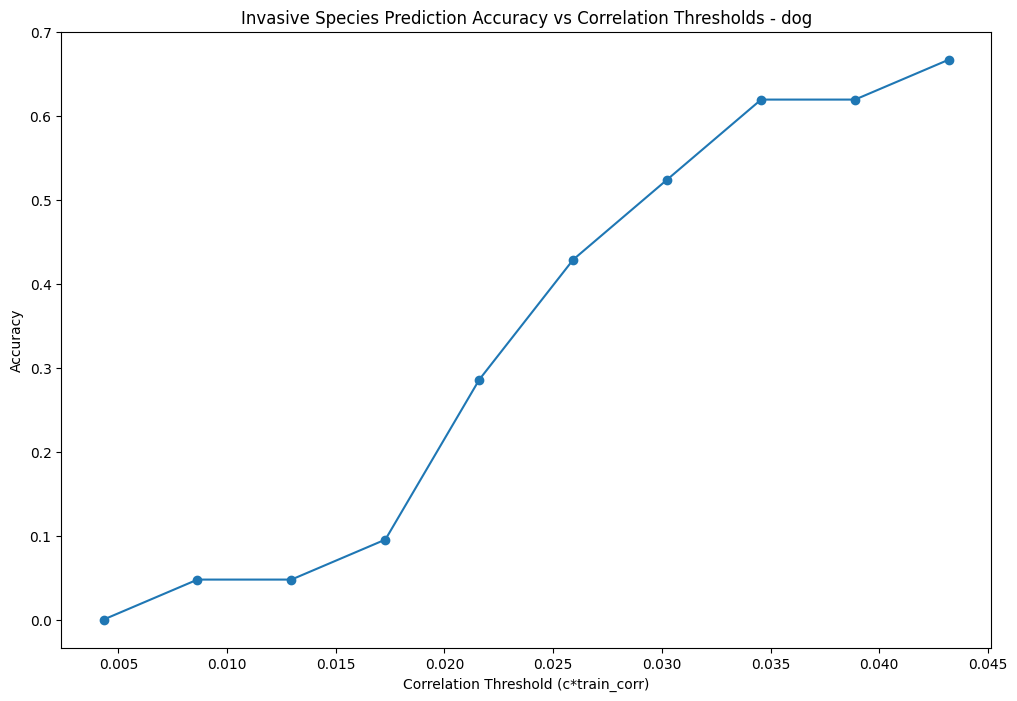

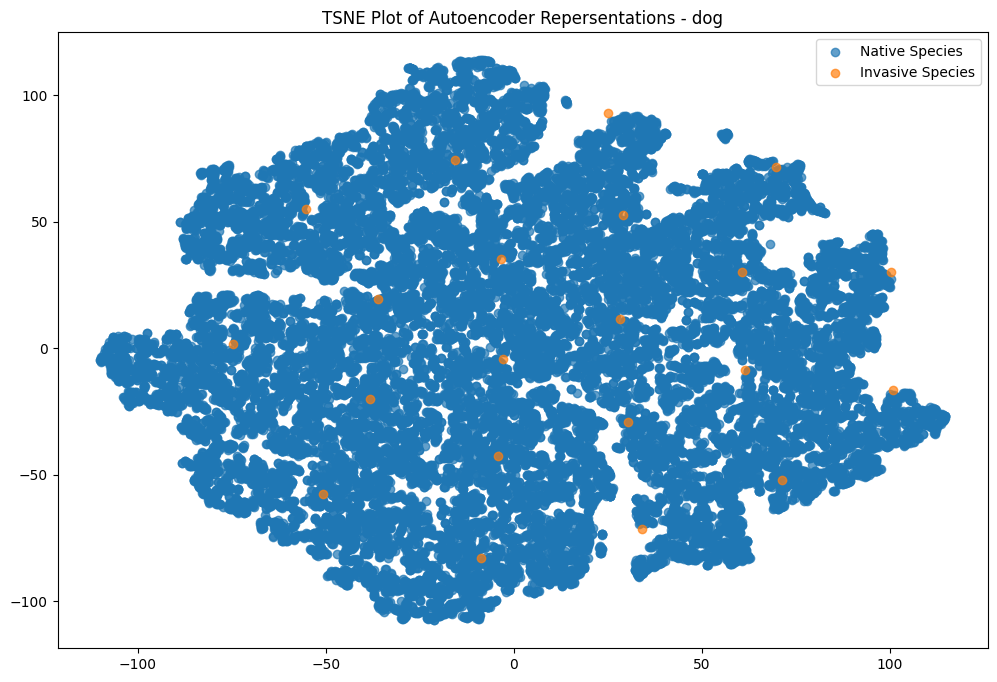

Epoch 1/5
897/897 - 96s - loss: 0.1763 - 96s/epoch - 108ms/step
Epoch 2/5
897/897 - 96s - loss: 0.1762 - 96s/epoch - 107ms/step
Epoch 3/5
897/897 - 95s - loss: 0.1763 - 95s/epoch - 106ms/step
Epoch 4/5
897/897 - 96s - loss: 0.1762 - 96s/epoch - 107ms/step
Epoch 5/5
897/897 - 96s - loss: 0.1764 - 96s/epoch - 107ms/step
898/898 [==============================] - 2s 2ms/step


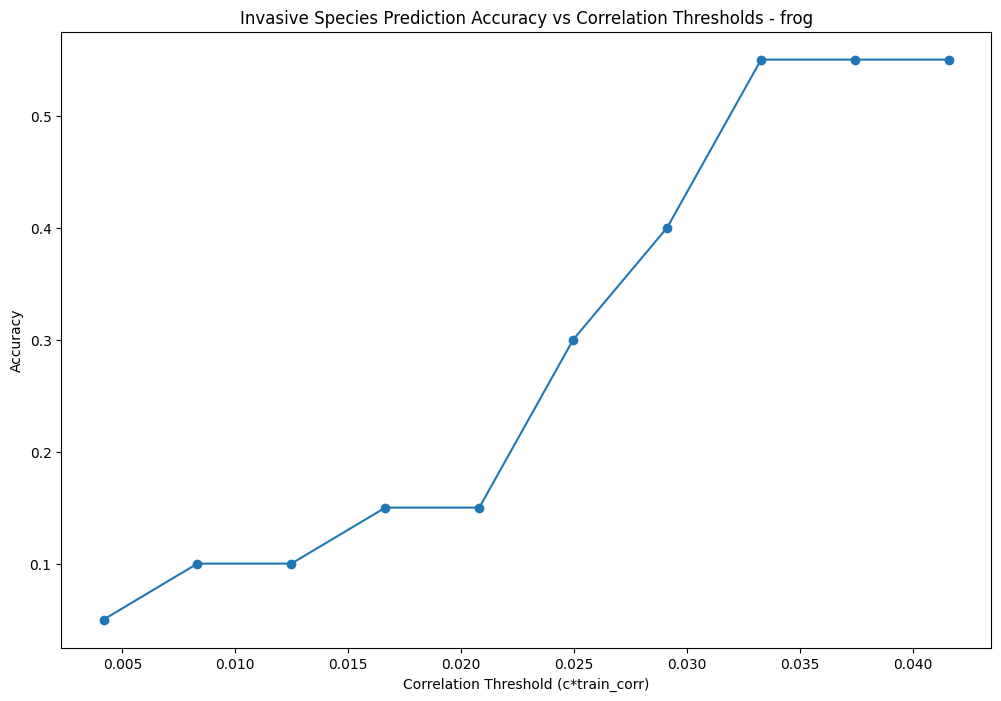

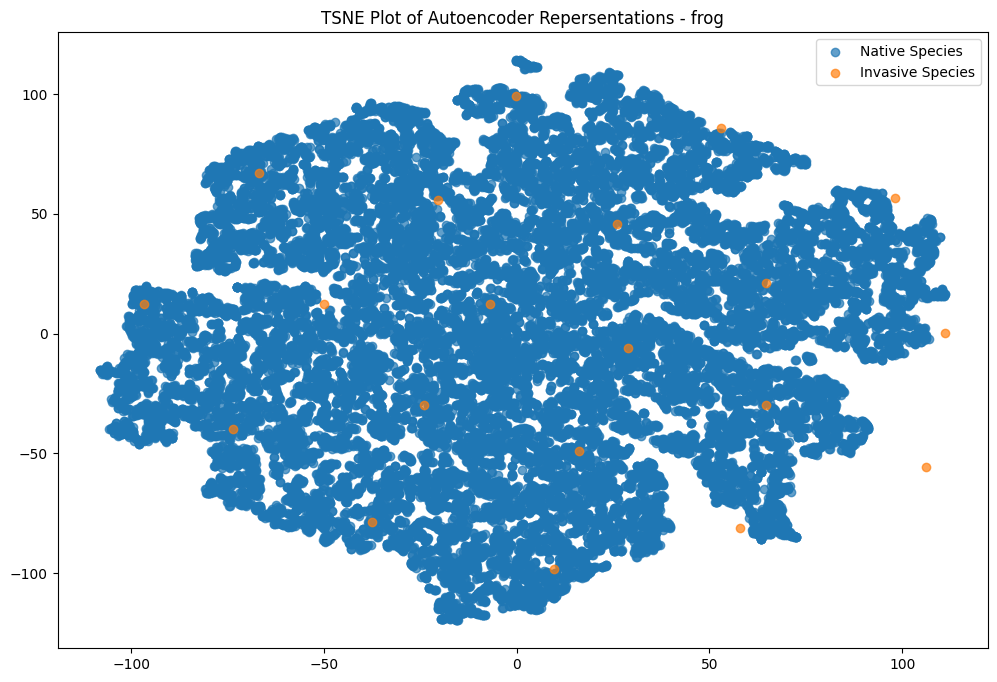

Epoch 1/5
897/897 - 98s - loss: 0.1763 - 98s/epoch - 109ms/step
Epoch 2/5
897/897 - 97s - loss: 0.1763 - 97s/epoch - 108ms/step
Epoch 3/5
897/897 - 97s - loss: 0.1762 - 97s/epoch - 108ms/step
Epoch 4/5
897/897 - 96s - loss: 0.1764 - 96s/epoch - 107ms/step
Epoch 5/5
897/897 - 96s - loss: 0.1761 - 96s/epoch - 107ms/step
898/898 [==============================] - 2s 2ms/step


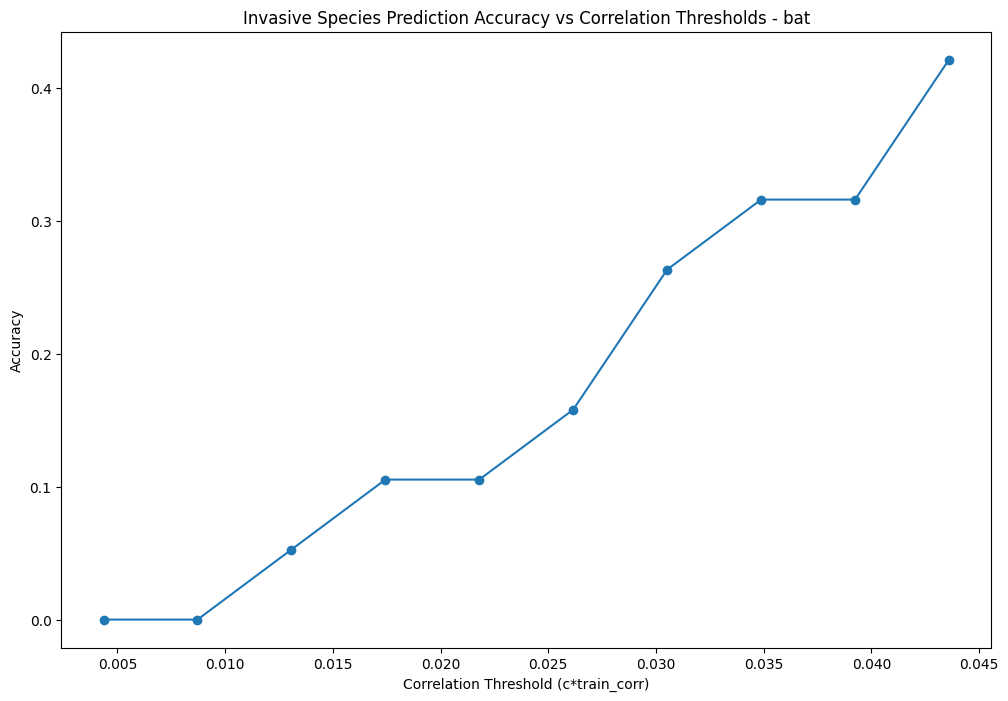

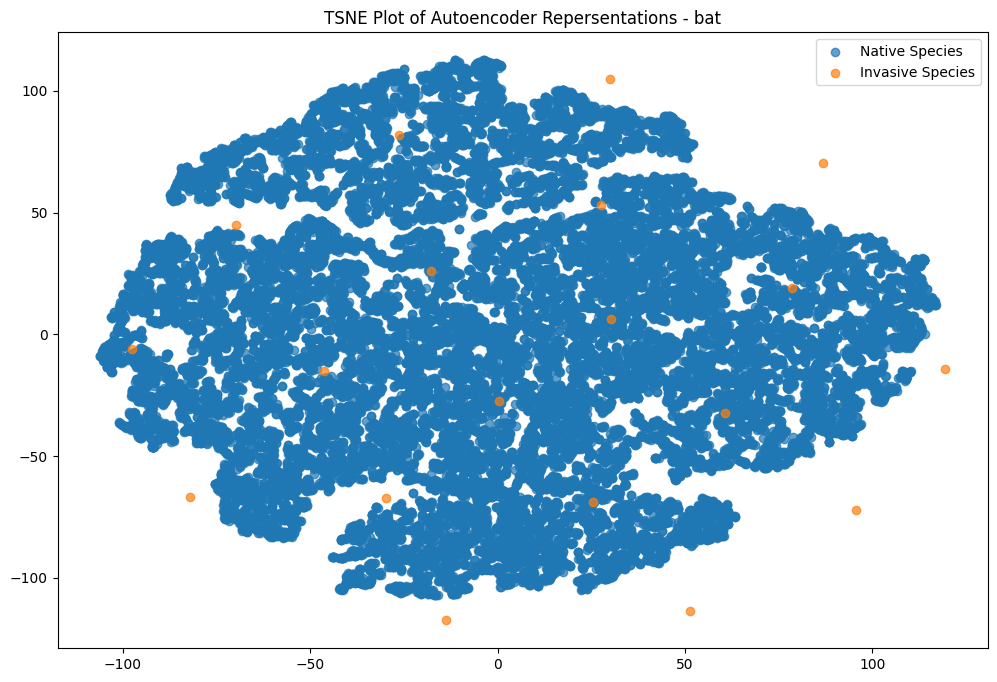

Epoch 1/5
897/897 - 97s - loss: 0.1763 - 97s/epoch - 108ms/step
Epoch 2/5
897/897 - 96s - loss: 0.1764 - 96s/epoch - 107ms/step
Epoch 3/5
897/897 - 96s - loss: 0.1763 - 96s/epoch - 107ms/step
Epoch 4/5
897/897 - 96s - loss: 0.1763 - 96s/epoch - 107ms/step
Epoch 5/5
897/897 - 96s - loss: 0.1763 - 96s/epoch - 108ms/step
898/898 [==============================] - 2s 2ms/step


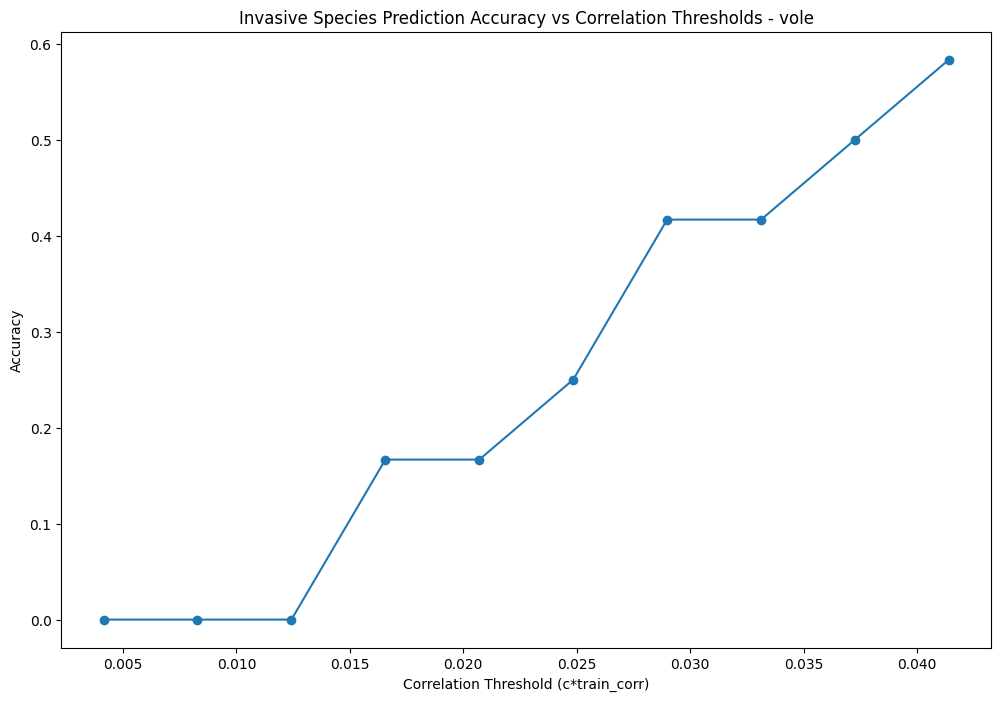

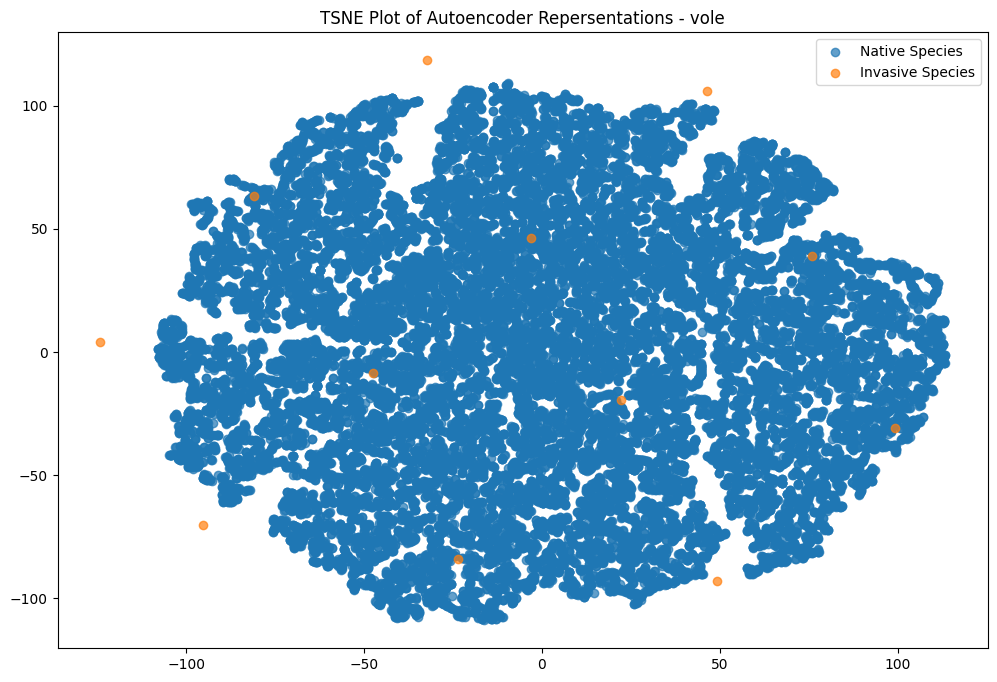

Epoch 1/5
897/897 - 97s - loss: 0.1763 - 97s/epoch - 108ms/step
Epoch 2/5
897/897 - 96s - loss: 0.1763 - 96s/epoch - 107ms/step
Epoch 3/5
897/897 - 96s - loss: 0.1762 - 96s/epoch - 107ms/step
Epoch 4/5
897/897 - 96s - loss: 0.1763 - 96s/epoch - 107ms/step
Epoch 5/5
897/897 - 96s - loss: 0.1763 - 96s/epoch - 107ms/step
898/898 [==============================] - 2s 2ms/step


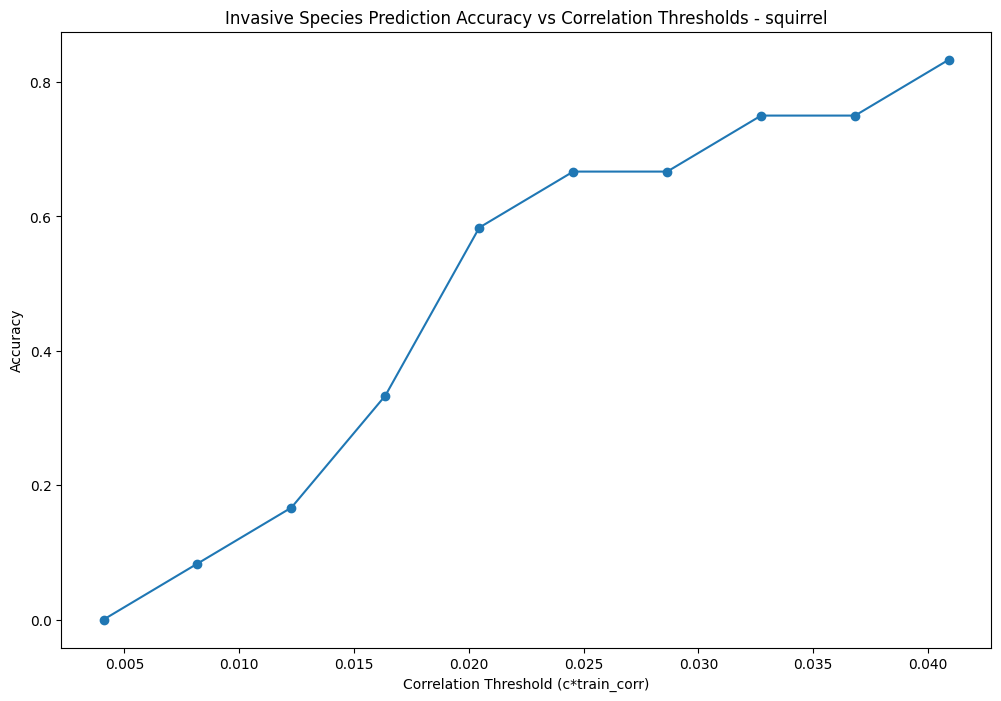

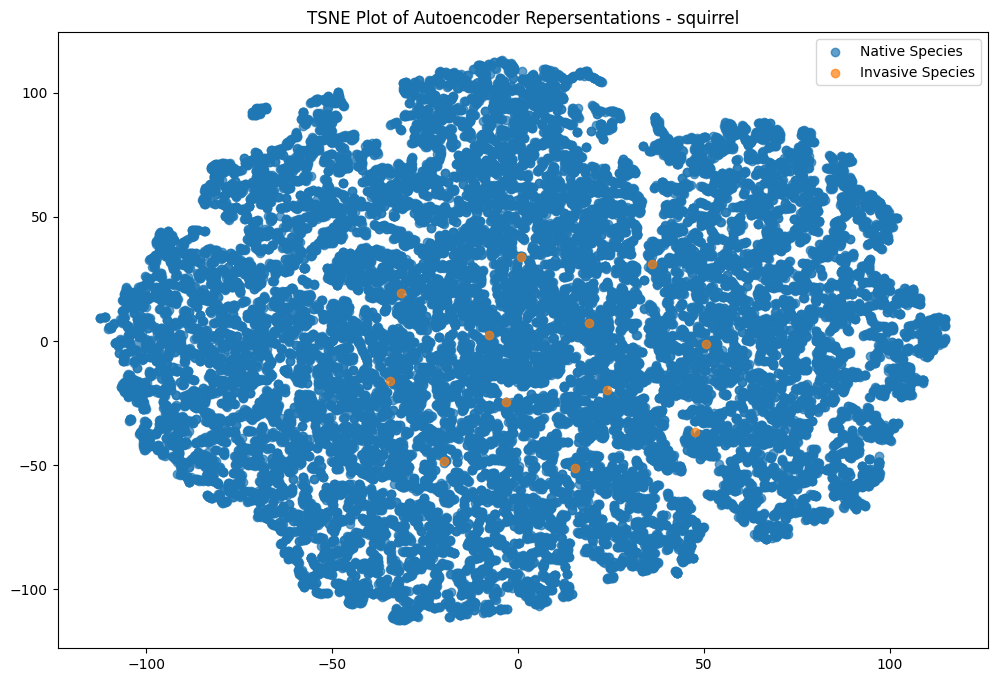

Epoch 1/5
897/897 - 96s - loss: 0.1763 - 96s/epoch - 108ms/step
Epoch 2/5
897/897 - 97s - loss: 0.1763 - 97s/epoch - 108ms/step
Epoch 3/5
897/897 - 96s - loss: 0.1763 - 96s/epoch - 107ms/step
Epoch 4/5
897/897 - 96s - loss: 0.1763 - 96s/epoch - 107ms/step
Epoch 5/5
897/897 - 96s - loss: 0.1763 - 96s/epoch - 107ms/step
898/898 [==============================] - 1s 2ms/step


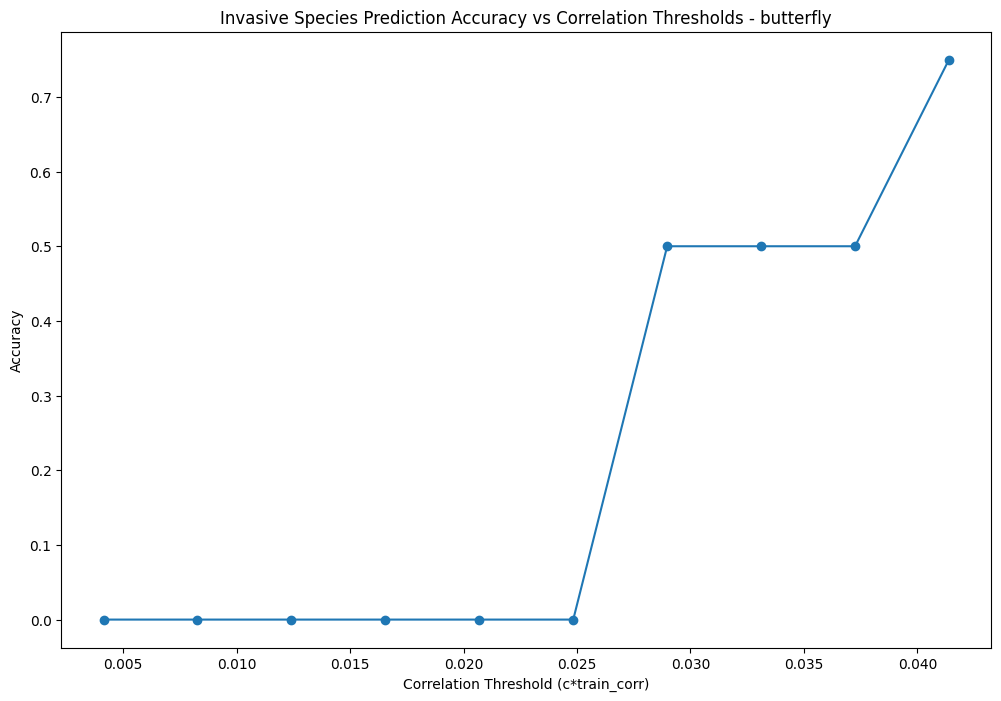

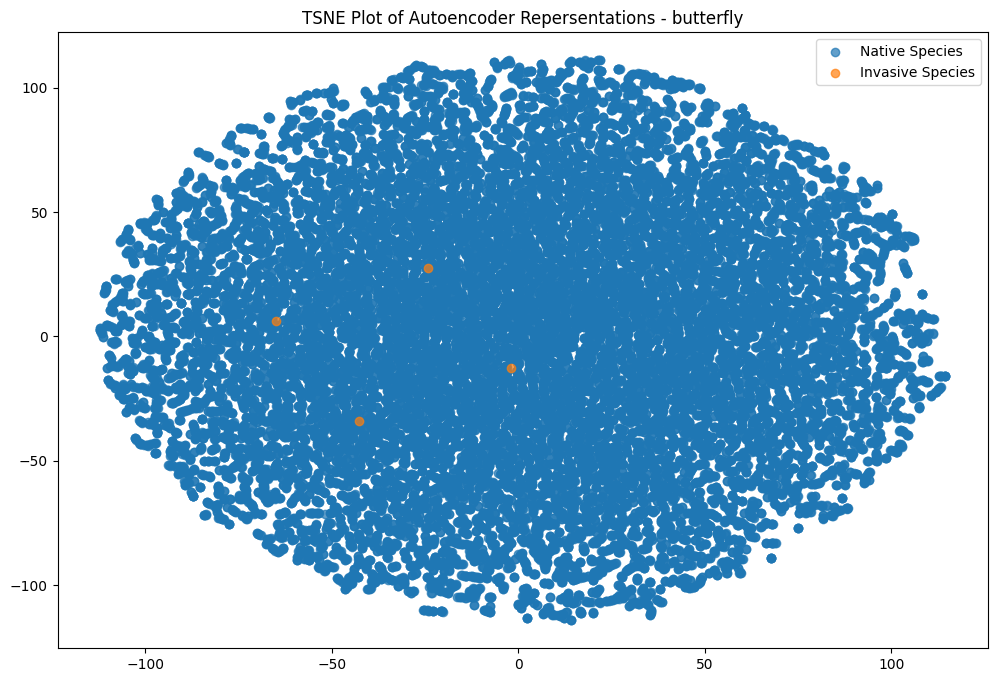

Epoch 1/5
897/897 - 98s - loss: 0.1763 - 98s/epoch - 109ms/step
Epoch 2/5
897/897 - 96s - loss: 0.1763 - 96s/epoch - 107ms/step
Epoch 3/5
897/897 - 96s - loss: 0.1764 - 96s/epoch - 106ms/step
Epoch 4/5
897/897 - 97s - loss: 0.1763 - 97s/epoch - 108ms/step
Epoch 5/5
897/897 - 97s - loss: 0.1763 - 97s/epoch - 108ms/step
898/898 [==============================] - 2s 2ms/step


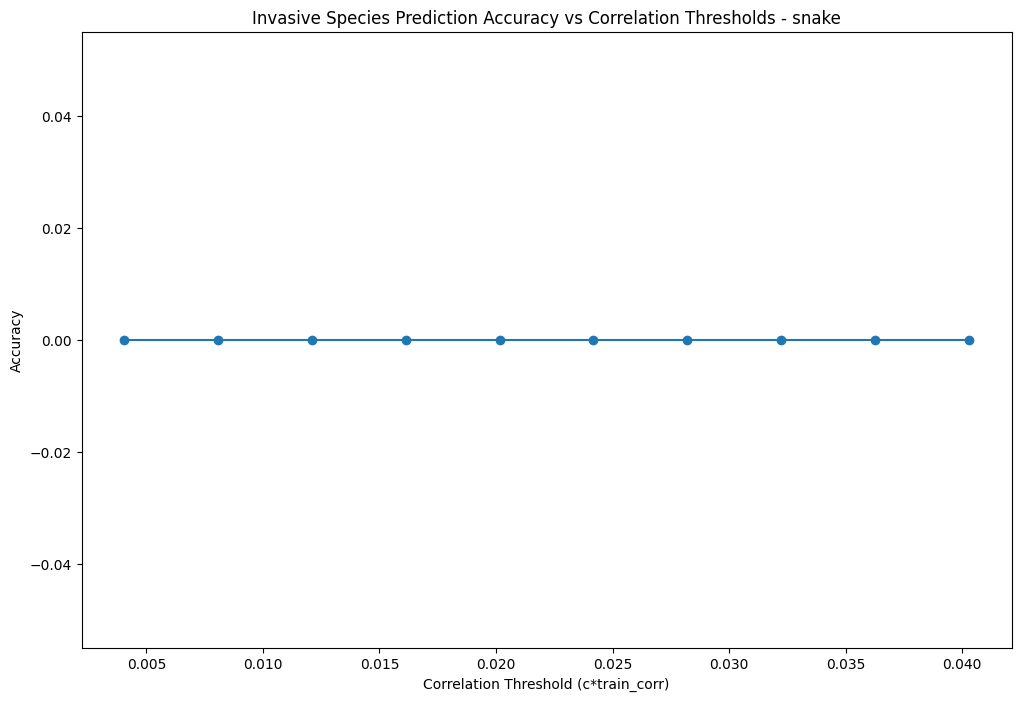

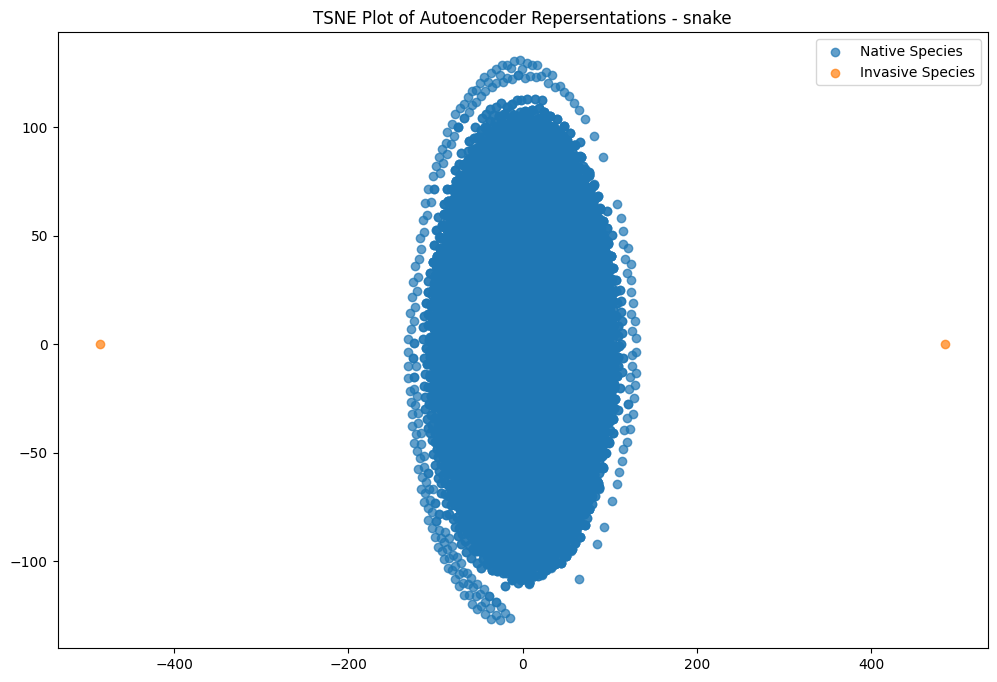

In [ ]:
images_folder_path = '/content/'
layers = [64, 32, 64] # autoencoder arch
target_size=(64, 64) # what we want to resize the image to - small because of colab issues, should probably increase

# train autoencoder and plot tsne results for each invasive species
models = {}
corr_results = {}
for invasive_species in invasive: # for each invasive species
    invasive_data = filtered_labels_df[filtered_labels_df['species_label'] == invasive_species]
    native_data = filtered_labels_df[filtered_labels_df['species_label'] != invasive_species]

    # get image file paths
    train_data_paths = [os.path.join(images_folder_path, filename) for filename in native_data['image_path']]
    invasive_data_paths = [os.path.join(images_folder_path, filename) for filename in invasive_data['image_path']]

    autoencoder = train_autoencoder_generator(train_data_paths, target_size, layers) # train
    models[invasive_species] = autoencoder # save model

    # results
    train_corr, invasive_data_flat, encoded_invasive, encoded_native = get_predictions(autoencoder, target_size, train_data_paths, invasive_data_paths) #inference
    c_list = np.arange(.1, 1.1, .1)
    corr_title = f"Invasive Species Prediction Accuracy vs Correlation Thresholds - {invasive_species}"
    corr_invs_accs = compute_accuracy_correlation(train_corr, invasive_data_flat, encoded_invasive, c_list, corr_title) # plot acc
    corr_results[invasive_species] = corr_invs_accs
    plot_tsne(encoded_native, encoded_invasive, f'TSNE Plot of Autoencoder Repersentations - {invasive_species}') # plot tsne


#2. Autoencoder for Species Repersentation
Training an autoencoder on all of the data, plotting the tsne plot color coded by species.

In [ ]:
# train autoencoder on all of the (filtered) species
train_data_paths = [os.path.join(images_folder_path, filename) for filename in filtered_labels_df['image_path']]
target_size = (64,64)
layers = [256, 128, 64, 32, 64, 128, 256]
autoencoder = train_autoencoder_generator(train_data_paths, target_size, layers, epochs = 10)

Epoch 1/10
897/897 - 101s - loss: 0.1763 - 101s/epoch - 112ms/step
Epoch 2/10
897/897 - 99s - loss: 0.1763 - 99s/epoch - 111ms/step
Epoch 3/10
897/897 - 98s - loss: 0.1763 - 98s/epoch - 109ms/step
Epoch 4/10
897/897 - 98s - loss: 0.1763 - 98s/epoch - 109ms/step
Epoch 5/10
897/897 - 97s - loss: 0.1763 - 97s/epoch - 108ms/step
Epoch 6/10
897/897 - 97s - loss: 0.1763 - 97s/epoch - 109ms/step
Epoch 7/10
897/897 - 97s - loss: 0.1763 - 97s/epoch - 108ms/step
Epoch 8/10
897/897 - 99s - loss: 0.1765 - 99s/epoch - 110ms/step
Epoch 9/10
897/897 - 99s - loss: 0.1761 - 99s/epoch - 110ms/step
Epoch 10/10
897/897 - 98s - loss: 0.1762 - 98s/epoch - 109ms/step


In [ ]:
# get repersentation
last_layer = autoencoder.layers[-1]
encoder_model = Model(inputs=autoencoder.input, outputs=last_layer.output)
all_images = resize_images(train_data_paths, target_size)
all_images_flat = all_images.reshape(all_images.shape[0], -1)
encoded_all = encoder_model.predict(all_images_flat)

898/898 [==============================] - 2s 2ms/step


In [ ]:
# tsne
tsne = TSNE(n_components=2, perplexity = encoded_all.shape[0]-1, random_state=42)
tsne_result = tsne.fit_transform(encoded_all)

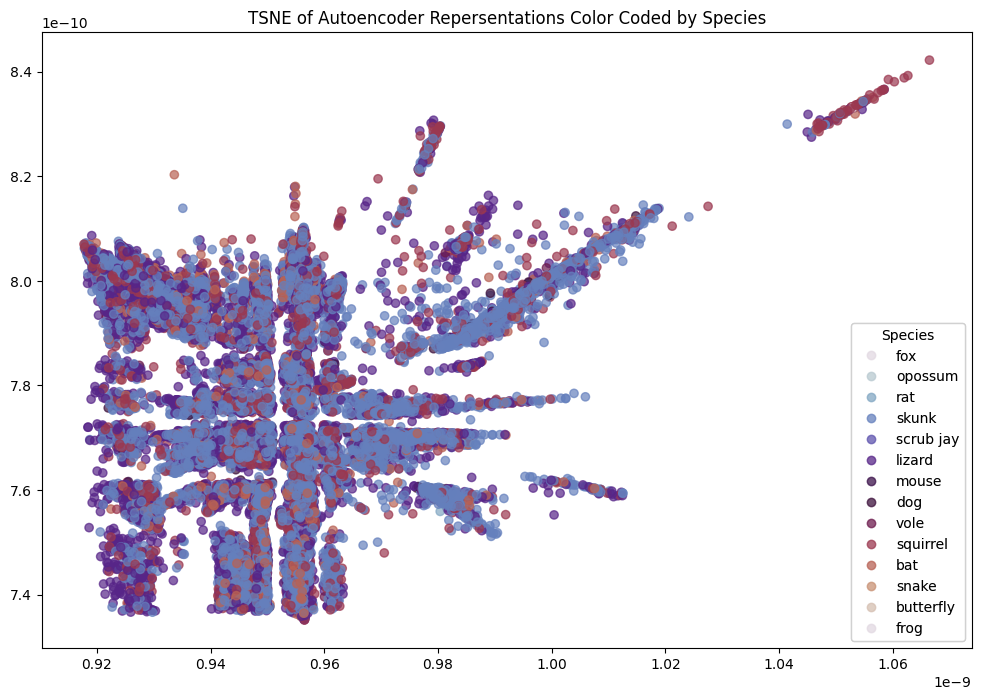

In [ ]:
# visualize
species_labels = filtered_labels_df['species_label'].astype('category').cat.codes
species_names = filtered_labels_df['species_label'].unique()
species_mapping = {code: name for code, name in zip(range(len(species_names)), species_names)}
species_labels_names = species_labels.map(species_mapping)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=species_labels, alpha=0.7, cmap='twilight')
handles, _ = scatter.legend_elements()
legend1 = plt.legend(handles, species_names, title='Species')
plt.gca().add_artist(legend1)
plt.title('TSNE of Autoencoder Repersentations Color Coded by Species')
plt.show()

In [12]:
labels_df['species_label'].unique()

array(['fox', 'opossum', 'rodent', 'bird', 'rat', 'skunk', 'scrub jay',
       'lizard', 'mouse', 'dog', 'vole', 'insect', 'squirrel', 'bat',
       'snake', 'butterfly', 'frog'], dtype=object)

In [8]:
# lets look at the more general (over-arching) categories
top_layer_species = ['rodent', 'bird', 'insect']
top_only = labels_df[labels_df['species_label'].isin(top_layer_species)]
top_only['species_label'].unique()

array(['rodent', 'bird', 'insect'], dtype=object)

In [9]:
# train
images_folder_path = '/content/'
top_data_paths = [os.path.join(images_folder_path, filename) for filename in top_only['image_path']]
target_size = (64,64)
layers = [128, 64, 32, 64, 128]
top_autoencoder = train_autoencoder_generator(top_data_paths, target_size, layers, epochs = 5)

Epoch 1/5
2536/2536 - 93s - loss: 0.1746 - 93s/epoch - 37ms/step
Epoch 2/5
2536/2536 - 49s - loss: 0.1746 - 49s/epoch - 19ms/step
Epoch 3/5
2536/2536 - 49s - loss: 0.1745 - 49s/epoch - 19ms/step
Epoch 4/5
2536/2536 - 48s - loss: 0.1746 - 48s/epoch - 19ms/step
Epoch 5/5
2536/2536 - 49s - loss: 0.1745 - 49s/epoch - 19ms/step


In [10]:
# get repersentation
def generate_image_batches(filepaths, batch_size, target_size):
    """
    Generator function to yield batches of resized images - prediction version
    """
    for i in range(0, len(filepaths), batch_size):
        batch_paths = filepaths[i:i + batch_size]
        batch_images = resize_images_batch(batch_paths, target_size)
        yield batch_images

    # Handle the last batch (which may be smaller than batch_size)
    if len(filepaths) % batch_size != 0:
        last_batch_paths = filepaths[-(len(filepaths) % batch_size):]
        last_batch_images = resize_images_batch(last_batch_paths, target_size)
        yield last_batch_images

top_last_layer = top_autoencoder.layers[-1]
top_encoder_model = Model(inputs=top_autoencoder.input, outputs=top_last_layer.output)
batch_size = 32
encoded_top = []

for batch_images in generate_image_batches(top_data_paths, batch_size, target_size):
    batch_images_flat = batch_images.reshape(batch_images.shape[0], -1)
    batch_encoded = top_encoder_model.predict(batch_images_flat)
    encoded_top.append(batch_encoded)

1/1 [==============================] - 0s 19ms/step


Everything below, I was not able to run (session crashes due to RAM issues). Not sure how to fix it, leaving it here for reference...

In [ ]:
# tsne
encoded_top = np.vstack(encoded_top)
top_tsne = TSNE(n_components=2, perplexity = encoded_top.shape[0]-1, random_state=42)
top_tsne_result = top_tsne.fit_transform(encoded_top)

In [ ]:
# visualize
top_species_labels = top_only['species_label'].astype('category').cat.codes
top_species_names = top_only['species_label'].unique()
top_species_mapping = {code: name for code, name in zip(range(len(top_species_names )), top_species_names )}
top_species_labels_names = top_species_labels.map(top_species_mapping)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(top_tsne_result[:, 0], top_tsne_result[:, 1], c=top_species_labels, alpha=0.7, cmap='twilight')
handles, _ = scatter.legend_elements()
legend1 = plt.legend(handles, top_species_names , title='Species')
plt.gca().add_artist(legend1)
plt.title('TSNE of Autoencoder Repersentations Color Coded by Species (High-level Categories)')
plt.show()